In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4/'
save_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(save_path, "icu", "admissions.csv"))
pre = pd.read_csv(os.path.join(file_path, "hosp", "prescriptions.csv"))

In [5]:
# Restrict the dataset to the previously selected admission ids only.
pre = pre.loc[pre["hadm_id"].isin(adm["hadm_id"])]

# Require a dose unit
print(pre["dose_unit_rx"].isna().sum())
pre = pre.drop(pre.loc[pre["dose_unit_rx"].isna()].index)
print(pre["dose_val_rx"].isna().sum())

print("Number of patients remaining in the database: ")
print(pre["subject_id"].nunique())
print("Number of datapoints remaining in the database: ")
print(len(pre))
pre.head()

551
0
Number of patients remaining in the database: 
10820
Number of datapoints remaining in the database: 
1015150


,subject_id,hadm_id,pharmacy_id,starttime,stoptime,drug_type,drug,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
1437,13120014,23768802,17287375,2187-11-02 22:00:00,2187-11-03 19:00:00,MAIN,Influenza Virus Vaccine,066525,3.333200e+10,0.5 mL Syringe,NaN,0.5,mL,1,SYR,0.0,IM
1438,13120014,23768802,2142265,2187-11-02 22:00:00,2187-11-03 19:00:00,MAIN,Pneumococcal Vac Polyvalent,048548,6.473900e+06,25mcg/0.5mL Vial,NaN,0.5,mL,1,VIAL,0.0,IM
1439,13120014,23768802,24380946,2187-11-02 22:00:00,2187-11-07 00:00:00,MAIN,Sodium Chloride 0.9% Flush,NaN,0.000000e+00,Syringe,NaN,3,mL,0.6,SYR,NaN,IV
1440,13120014,23768802,26602570,2187-11-02 22:00:00,2187-11-05 11:00:00,MAIN,Lorazepam,003753,4.091985e+08,2mg/mL Syringe,NaN,0.25,mg,0.125,mL,NaN,IV
1441,13120014,23768802,9449939,2187-11-02 23:00:00,2187-11-03 19:00:00,MAIN,HydrALAzine,000283,5.170901e+08,20mg/mL Vial,NaN,10,mg,0.5,VIAL,1.0,IV


In [6]:
n_best = 50
# For each item, evaluate the number of patients who have been given this item.
pat_for_presc = pre.groupby("drug")["subject_id"].nunique()
# Order by occurence and take the 50 best (the ones with the most patients)
frequent_labels = pat_for_presc.sort_values(ascending=False)[:n_best]

# Select only the time series with high occurence.
pre = pre.loc[pre["drug"].isin(list(frequent_labels.index))]

print(frequent_labels)
print("Number of patients remaining in the database: ")
print(pre["subject_id"].nunique())
print("Number of datapoints remaining in the database: ")
print(len(pre))

drug
Sodium Chloride 0.9%  Flush                 10527
0.9% Sodium Chloride                         9361
Acetaminophen                                9051
Magnesium Sulfate                            8560
Potassium Chloride                           8216
Heparin                                      8085
Docusate Sodium                              7554
Bag                                          7117
Senna                                        7013
Calcium Gluconate                            6799
Insulin                                      6684
5% Dextrose                                  6666
Iso-Osmotic Dextrose                         6391
Dextrose 50%                                 6383
Bisacodyl                                    6008
Glucagon                                     5904
Ondansetron                                  5396
Furosemide                                   5253
Propofol                                     5140
Metoprolol Tartrate                          

In [7]:
# #Select entries whose drug name is in the list from the paper.
# drugs_list=["Aspirin","Bisacodyl","Docusate Sodium","D5W","Humulin-R Insulin","Potassium Chloride","Magnesium Sulfate","Metoprolol Tartrate","Sodium Chloride 0.9%  Flush","Pantoprazole"]
# presc2=presc.loc[presc["DRUG"].isin(drugs_list)]

# print("Number of patients remaining in the database: ")
# print(presc2["SUBJECT_ID"].nunique())

### Units Cleaning

#### 1) In amounts

In [8]:
pre.groupby("drug")["dose_unit_rx"].value_counts(dropna=False)

drug                                      dose_unit_rx          
0.9% Sodium Chloride                      mL                        47212
                                          BAG                       13288
                                          mg                            1
0.9% Sodium Chloride (Mini Bag Plus)      mL                         6960
                                          BAG                         170
5% Dextrose                               mL                        28644
                                          SYR                           5
                                          BAG                           1
Acetaminophen                             mg                        22021
                                          g                             6
Acetaminophen IV                          mg                         7527
Albuterol 0.083% Neb Soln                 NEB                        4348
                                          mg   

In [9]:
# Units correction
pre = pre.drop(pre.loc[(pre["drug"] == "0.9% Sodium Chloride") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "0.9% Sodium Chloride (Mini Bag Plus)") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "5% Dextrose") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Acetaminophen") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Albuterol 0.083% Neb Soln") & (pre["dose_unit_rx"] != "NEB")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Bag") & (pre["dose_unit_rx"] != "BAG")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Calcium Gluconate") & (pre["dose_unit_rx"] != "g")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "D5W") & (pre["dose_unit_rx"] != "mL")].index)

pre = pre.drop(pre.loc[(pre["drug"] == "Fentanyl Citrate") & (pre["dose_unit_rx"] == "mcg/hr")].index)
cond = (pre["drug"] == "Fentanyl Citrate") & (pre["dose_unit_rx"] == "mg")
pre["dose_val_rx"] += 999 * cond * pre["dose_val_rx"]
pre["dose_unit_rx"].loc[cond] = "mcg"

pre = pre.drop(pre.loc[(pre["drug"] == "HYDROmorphone (Dilaudid)") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Heparin Flush (10 units/ml)") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Insulin Human Regular") & (pre["dose_unit_rx"] != "UNIT")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Iso-Osmotic Sodium Chloride") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Lactated Ringers") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Neutra-Phos") & (pre["dose_unit_rx"] != "PKT")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Nitroglycerin") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "PHENYLEPHrine") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Propofol") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Senna") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Sodium Chloride 0.9%") & (pre["dose_unit_rx"] != "mL")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Vancomycin") & (pre["dose_unit_rx"] != "mg")].index)
pre = pre.drop(pre.loc[(pre["drug"] == "Vial") & (pre["dose_unit_rx"] != "VIAL")].index)

pre.groupby("drug")["dose_unit_rx"].value_counts(dropna=False)

drug                                      dose_unit_rx
0.9% Sodium Chloride                      mL              47212
0.9% Sodium Chloride (Mini Bag Plus)      mL               6960
5% Dextrose                               mL              28644
Acetaminophen                             mg              22021
Acetaminophen IV                          mg               7527
Albuterol 0.083% Neb Soln                 NEB              4348
Aspirin                                   mg               6890
Atorvastatin                              mg               4283
Bag                                       BAG             15718
Bisacodyl                                 mg              11168
Calcium Gluconate                         g               17601
Chlorhexidine Gluconate 0.12% Oral Rinse  mL               5027
D5W                                       mL               5064
Dextrose 50%                              gm               9959
Docusate Sodium                           mg     

### Check for outliers

#### 1) In amounts

In [10]:
pre["dose_val_rx"].value_counts(dropna=False)

100          60407
1000         60011
2            40076
20           36874
1            33424
             ...  
0-400            1
72               1
0.5-2.5          1
0.2-1.0          1
2900-5000        1
Name: dose_val_rx, Length: 619, dtype: int64

In [11]:
# Transform the value columns to float
original_num_entries = len(pre.index)

# Remove rows with letters in dose_val_rx
pre = pre.loc[~pre["dose_val_rx"].str.contains('[A-Za-z]')]

# Transform the ranges (xx-yy) as the mean of the ranges.
range_df = pre.loc[pre["dose_val_rx"].str.contains("-")]
range_df["First digit"] = range_df["dose_val_rx"].str.split("-").str[0].astype(float)
range_df["Second digit"] = range_df["dose_val_rx"].str.split("-").str[1]
range_df.loc[range_df["Second digit"] == "", "Second digit"] = range_df.loc[range_df["Second digit"] == "", 'First digit']
range_df["Second digit"] = range_df["Second digit"].astype(float)
range_df["mean"] = (range_df["First digit"] + range_df["Second digit"]) / 2
range_df["dose_val_rx"] = range_df["mean"]
range_df.drop(columns=["First digit", "Second digit", "mean"], inplace=True)

# Now remove the entries with the - from the original df and force conversion to float.
pre=pre.drop(pre.loc[pre["dose_val_rx"].str.contains("-")].index)
pre["dose_val_rx"] = pd.to_numeric(pre["dose_val_rx"], errors="coerce")
pre.dropna(subset=["dose_val_rx"], inplace=True)

pre = pre.append(range_df)

print("Lost entries in the process: {}".format(original_num_entries - len(pre)))

Lost entries in the process: 4178


In [12]:
pre.groupby("drug")["dose_val_rx"].describe()

,count,mean,std,min,25%,50%,75%,max
drug,,,,,,,,
0.9% Sodium Chloride,47212.0,368.933352,326.572389,0.00,100.00,250.00,500.00,5000.0
0.9% Sodium Chloride (Mini Bag Plus),6960.0,99.992816,1.340218,0.00,100.00,100.00,100.00,150.0
5% Dextrose,28644.0,274.403627,234.185524,0.00,100.00,250.00,250.00,3000.0
Acetaminophen,22021.0,686.879002,171.022904,250.00,650.00,650.00,650.00,1300.0
Acetaminophen IV,7527.0,990.676897,66.544465,325.00,1000.00,1000.00,1000.00,1000.0
Albuterol 0.083% Neb Soln,4348.0,1.019434,0.160233,0.00,1.00,1.00,1.00,3.0
Aspirin,6890.0,144.783817,107.237783,40.50,81.00,81.00,300.00,650.0
Atorvastatin,4283.0,53.418165,27.764725,5.00,20.00,40.00,80.00,80.0
Bag,15718.0,1.329018,0.471949,0.00,1.00,1.00,2.00,3.0


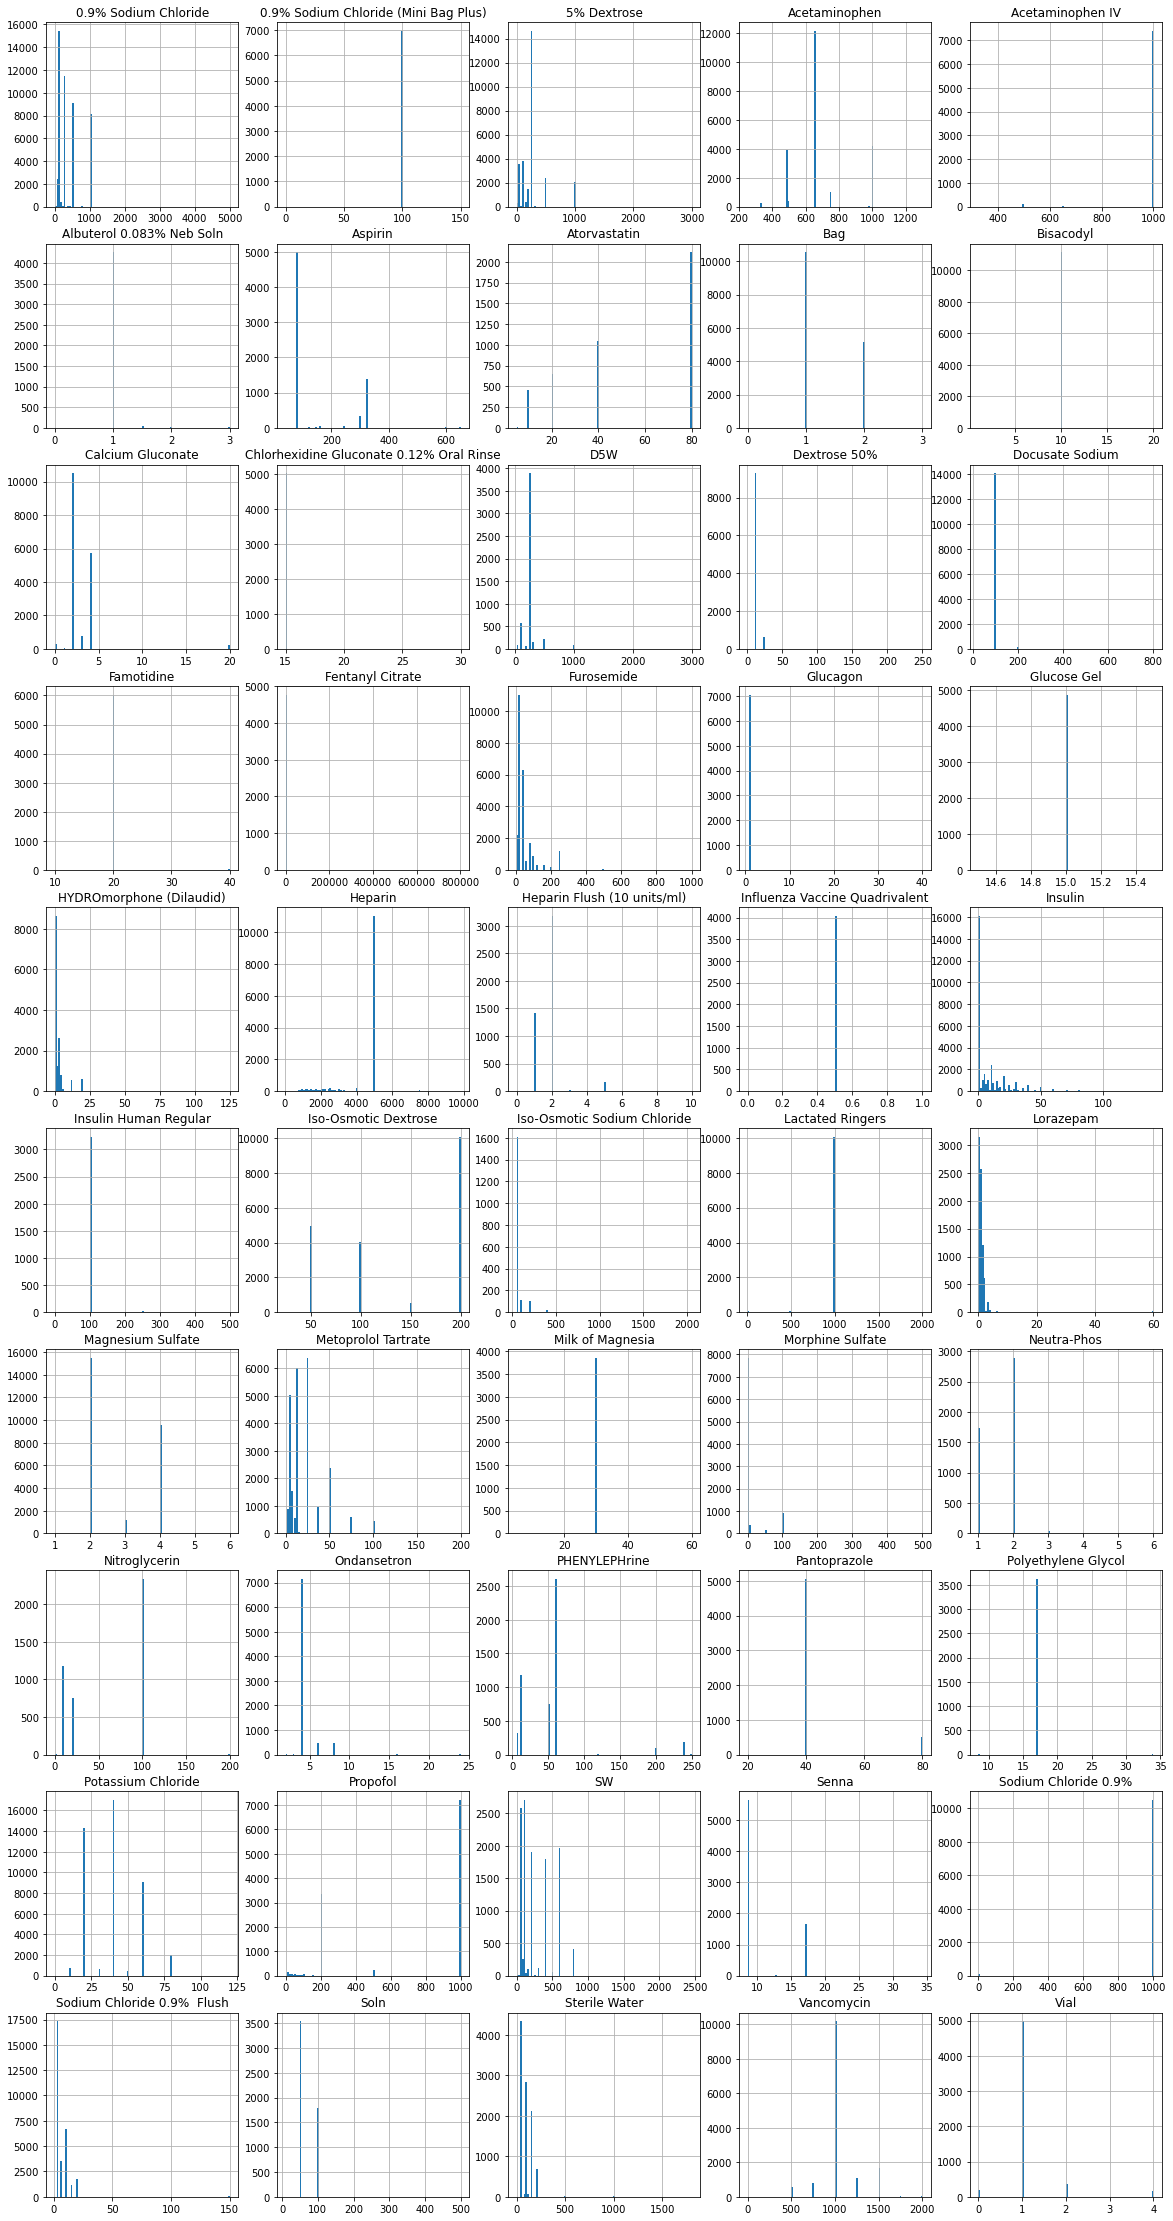

In [13]:
plt.figure(figsize=(20, 40))
for i, drug in enumerate(sorted(pre["drug"].unique())):
    plt.subplot(10, 5, 1+i)
    pre["dose_val_rx"][pre["drug"] == drug].hist(bins=100)
    plt.title(drug)

In [14]:
# To avoid confounding labels with labels from other tables, add "drug" to the name
pre["drug"] = pre["drug"] + " Drug"

In [15]:
# Drop a few remaining incorrect start times
print(pre["starttime"].isna().sum())
pre = pre.drop(pre.loc[pre["starttime"].isna()].index)
pre["starttime"].isna().sum()

30


0

In [16]:
pre.to_csv(os.path.join(save_path, "hosp", "prescriptions.csv"))

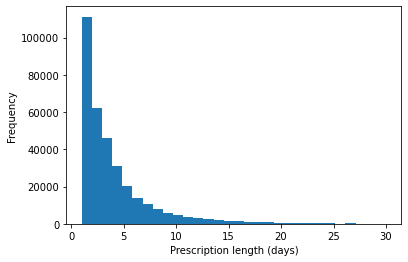

In [17]:
pre['starttime'] = pd.to_datetime(pre["starttime"], format='%Y-%m-%d %H:%M:%S')
pre['stoptime'] = pd.to_datetime(pre["stoptime"], format='%Y-%m-%d %H:%M:%S')

pre["elapsed_time"] = pre["stoptime"] - pre["starttime"]
pre["elapsed_days"] = pre["elapsed_time"].dt.days
cond = pre["elapsed_days"].notnull() & (pre["elapsed_days"] > 0) & (pre["elapsed_days"] < 300)
plt.hist(pre.loc[cond, "elapsed_days"], bins=30)
_ = plt.xlabel("Prescription length (days)"), plt.ylabel("Frequency"), plt.show()